# TF-IDF Evaluation

In [1]:
%load_ext autoreload
%autoreload 2
import json
from gensim.summarization.bm25 import BM25
from gensim.models.phrases import Phrases, Phraser
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)
import numpy as np
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
sns.set()


from tqdm.notebook import tqdm
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

import sys
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)


from tfidf_retrieval import TfidfRetrieval
from evaluation import *
from preprocessing import apply_pipeline, Corpus, BasicPreprocessing, BigramPreprocessor, SpacyPreprocessor

#### Load corpus using different preprocessing pipelines

In [2]:
base_file =  "../data/kit_expert_2017_papers.csv"

p = [BasicPreprocessing()]
papers_basic = Corpus(base_file, p)

p = [BasicPreprocessing(), SpacyPreprocessor(lemmatization="all")]
papers_basic_lemmatization_all = Corpus(base_file, p, load_from_cache=True)

p = [BasicPreprocessing(), SpacyPreprocessor(lemmatization="nouns")]
papers_basic_lemmatization_nouns = Corpus(base_file, p, load_from_cache=True)

INFO:preprocessing.pipeline:Start preprocessing pipeline "basic" for file ../data/kit_expert_2017_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_spacy_lemmatization_all" for file ../data/kit_expert_2017_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic_spacy_lemmatization_all
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_spacy_lemmatization_nouns" for file ../data/kit_expert_2017_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic_spacy_lemmatization_nouns


#### Load keywords to use as test data

In [3]:
with open("../data/kit_expert_2017_keywords.json", "r") as file:
    keywords = json.load(file)

In [4]:
general_keywords = ("general keywords", [k for k in keywords if k["level"]<=1])
specific_keywords = ("specific_keywords", [k for k in keywords if k["level"]>=2][:5000])

#### Test simple tf-idf models on unigrams

In [5]:
unigram_tfidf_models = [
    ("tf linear", partial(TfidfRetrieval, corpus = papers_basic, max_ngram=1, use_idf=False, sublinear_tf=False)),
    ("tf sublinear", partial(TfidfRetrieval, corpus = papers_basic, max_ngram=1, use_idf=False, sublinear_tf=True)),
    ("tf-idf linear", partial(TfidfRetrieval, corpus = papers_basic, max_ngram=1, use_idf=True, sublinear_tf=False)),
    ("tf-idf sublinear", partial(TfidfRetrieval, corpus = papers_basic, max_ngram=1, use_idf=True, sublinear_tf=True)),
]

In [ ]:
unigram_tfidf_results = train_evaluate_models(unigram_tfidf_models, [general_keywords, specific_keywords], n_jobs=4)

In [7]:
print("mAP scores for unigram tfidf models:")
unigram_tfidf_results

mAP scores for unigram tfidf models:


,general keywords,specific_keywords
tf linear,0.048705,0.315517
tf sublinear,0.054267,0.411899
tf-idf linear,0.049875,0.384793
tf-idf sublinear,0.051161,0.457455


Results:
- Performs very bad on general keywords
- Performs ok on specific keywords
- Use of inverse document frequency improves result 
- Use of sublinear scaling of term frequency improves results 

#### Test tf-idf models on n-grams

In [8]:
ngram_tfidf_models = [
    ("tf-idf sublinear 2-gram", partial(TfidfRetrieval, corpus=papers_basic, max_ngram=2, use_idf=True, sublinear_tf=True)),
    ("tf-idf sublinear 3-gram", partial(TfidfRetrieval, corpus=papers_basic, max_ngram=3, use_idf=True, sublinear_tf=True)),
    ("tf-idf sublinear 4-gram", partial(TfidfRetrieval, corpus=papers_basic, max_ngram=4, use_idf=True, sublinear_tf=True)),
]

In [ ]:
ngram_tfidf_results = train_evaluate_models(ngram_tfidf_models, [general_keywords, specific_keywords], n_jobs=5)

In [29]:
print("mAP scores for ngram tfidf models:")
ngram_tfidf_results

mAP scores for ngram tfidf models:


,general keywords,specific_keywords
tf-idf sublinear 2-gram,0.053622,0.607080
tf-idf sublinear 3-gram,0.054342,0.615207
tf-idf sublinear 4-gram,0.054552,0.615690


Results:
- No significant change for general keywords
- Bigrams provide great improvement for specific keywords
- 3 and 4-grams do not lead to significant further improvements

In [ ]:
lemmatization_tfidf_models = [
    ("tf-idf 1-gram lematization all", partial(TfidfRetrieval, corpus = papers_basic_lemmatization_all, max_ngram=1, use_idf=True, sublinear_tf=True)),
    ("tf-idf 1-gram lematization nouns", partial(TfidfRetrieval, corpus = papers_basic_lemmatization_nouns, max_ngram=1, use_idf=True, sublinear_tf=True)),
    ("tf-idf 2-gram lematization all", partial(TfidfRetrieval, corpus = papers_basic_lemmatization_all, max_ngram=2, use_idf=True, sublinear_tf=True)),
    ("tf-idf 2-gram lematization nouns", partial(TfidfRetrieval, corpus = papers_basic_lemmatization_nouns, max_ngram=2, use_idf=True, sublinear_tf=True)),
]

In [ ]:
lemmatization_tfidf_results = train_evaluate_models(lemmatization_tfidf_models, [general_keywords, specific_keywords], n_jobs=4)

In [30]:
print("mAP scores for lemmatization tfidf models:")
lemmatization_tfidf_results

mAP scores for lemmatization tfidf models:


,general keywords,specific_keywords
tf-idf 1-gram lematization all,0.052131,0.443485
tf-idf 1-gram lematization nouns,0.052932,0.453880
tf-idf 2-gram lematization all,0.054516,0.602975
tf-idf 2-gram lematization nouns,0.055375,0.615382


#### Grid search for BM25 k1 parameter

In [6]:
k1_grid = np.arange(0.1,1.5,0.1)
search_k1_bm25_models = [(f"BM25 k1={k1:.2f}", partial(TfidfRetrieval, corpus=papers_basic, use_bm25=True, k1=k1)) for k1 in k1_grid]

In [ ]:
%%time
search_k1_bm25_results = train_evaluate_models(search_k1_bm25_models, [general_keywords, specific_keywords], n_jobs=len(search_k1_bm25_models))

In [8]:
print("mAP scores for bm25 k1 search models:")
search_k1_bm25_results

mAP scores for bm25 k1 search models:


,general keywords,specific_keywords
BM25 k1=0.10,0.035042,0.450762
BM25 k1=0.20,0.037415,0.459711
BM25 k1=0.30,0.040201,0.466010
BM25 k1=0.40,0.041391,0.471763
BM25 k1=0.50,0.042846,0.474780
BM25 k1=0.60,0.044383,0.476522
BM25 k1=0.70,0.045310,0.477743
BM25 k1=0.80,0.046103,0.479169
BM25 k1=0.90,0.047374,0.478976
BM25 k1=1.00,0.047386,0.478830


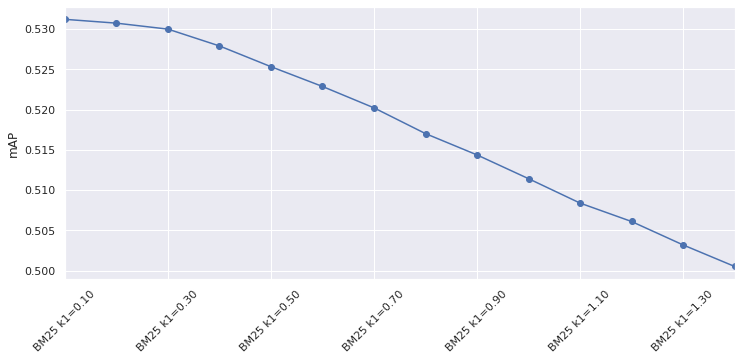

In [34]:
ax = search_k1_bm25_results["specific_keywords"].plot(figsize=(12,5), style="-bo", rot=45, legend=False)
ax.set_ylabel("mAP");

Results:
- k1 of 0.2 has the best performance

#### Grid search for BM25 b parameter

In [5]:
b_grid = np.arange(0.1,1.1,0.1)
search_b_bm25_models = [(f"BM25 b={b:.2f}", partial(TfidfRetrieval, corpus=papers_basic, use_bm25=True, b=b, k1=0.2)) for b in b_grid]

In [ ]:
%%time
search_b_bm25_results = train_evaluate_models(search_b_bm25_models, [general_keywords, specific_keywords], n_jobs=len(search_b_bm25_models))

In [32]:
print("mAP scores for bm25 b search models:")
search_b_bm25_results

mAP scores for bm25 b search models:


,general keywords,specific_keywords
BM25 b=0.10,0.054874,0.522593
BM25 b=0.20,0.055107,0.524565
BM25 b=0.30,0.055184,0.526734
BM25 b=0.40,0.055502,0.527595
BM25 b=0.50,0.055383,0.529235
BM25 b=0.60,0.055352,0.529695
BM25 b=0.70,0.055046,0.530505
BM25 b=0.80,0.055030,0.530794
BM25 b=0.90,0.055027,0.529518
BM25 b=1.00,0.053787,0.528531


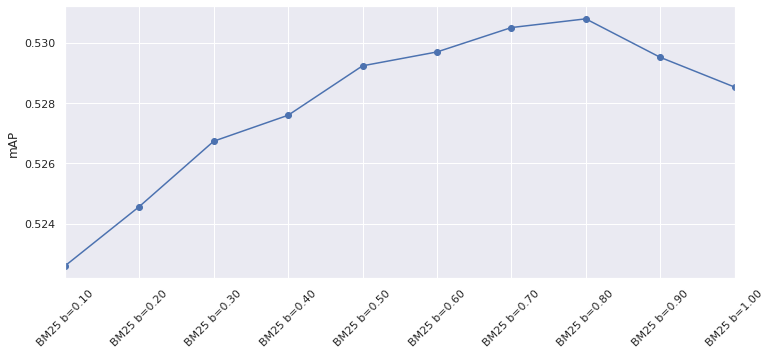

In [33]:
ax = search_b_bm25_results["specific_keywords"].plot(figsize=(12,5), style="-bo", rot=45, legend=False)
ax.set_ylabel("mAP");

Results:
- b parameter does not have a great effect on model performance
- best value at 0.7

#### Test bm25 with best parameters on n-grams

In [17]:
ngram_bm25_models = [
    ("bm25 2-gram", partial(TfidfRetrieval, corpus=papers_basic, max_ngram=2, use_bm25=True, k1=0.2, b=0.7)),
    ("bm25 3-gram", partial(TfidfRetrieval, corpus=papers_basic, max_ngram=3, use_bm25=True, k1=0.2, b=0.7)),
]

In [ ]:
ngram_bm25_results = train_evaluate_models(ngram_bm25_models, [general_keywords, specific_keywords])

In [35]:
print("mAP scores for ngram bm25 models:")
ngram_bm25_results

mAP scores for ngram bm25 models:


,general keywords,specific_keywords
bm25 2-gram,0.054687,0.618666
bm25 3-gram,0.054675,0.618989


Results:
- bigrams improve result of bm25
- bm25 bigram model achieves best score on specific keywords
- general keyword score still very low

In [7]:
from query_expansion_retrieval import QueryExpansionRetrieval

In [8]:
with open("../data/keyword_hierarchy.json", 'r') as file:
    keyword_hierarchy = json.load(file)

In [15]:
bm25_model_unigram = TfidfRetrieval(corpus=papers_basic, max_ngram=1, use_bm25=True, k1=0.2, b=0.7)
bm25_model_bigram = TfidfRetrieval(corpus=papers_basic, max_ngram=2, use_bm25=True, k1=0.2, b=0.7)

In [41]:
query_expansion_models = [
    ("qe unigram expand all", 
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=False,
             separate_weighting=False)),
    ("qe unigram expand first",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=False)),
    ("qe bigram expand all", 
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_bigram,
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=False,
             separate_weighting=False)),
    ("qe bigram expand first",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_bigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=False)),
    ("qe unigram expand all separate weighting",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=False,
             separate_weighting=True)),
    ("qe unigram expand first separate weighting",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=True))
]

In [ ]:
query_expansion_results = train_evaluate_models(query_expansion_models, [general_keywords, specific_keywords])

INFO:root:Start training model qe unigram expand all
INFO:root:Start training model qe unigram expand first
INFO:root:Start evaluating model qe unigram expand all


INFO:root:Start evaluating model qe unigram expand first


INFO:root:Start training model qe bigram expand all
INFO:root:Start evaluating model qe bigram expand all


INFO:root:Start training model qe bigram expand first
INFO:root:Start evaluating model qe bigram expand first


In [44]:
print("mAP scores for query expansion models:")
query_expansion_results

mAP scores for query expansion models:


,general keywords,specific_keywords
qe unigram expand all,0.115694,0.436585
qe unigram expand first,0.141666,0.444082
qe bigram expand all,0.135888,0.524883
qe bigram expand first,0.141590,0.531907
qe unigram expand all separate weighting,0.064065,0.531431
qe unigram expand first separate weighting,0.063396,0.531243


In [7]:
bm25_model_unigram = TfidfRetrieval(corpus=papers_basic_lemmatization_nouns, max_ngram=1, use_bm25=True, k1=0.2, b=0.7)
bm25_model_bigram = TfidfRetrieval(corpus=papers_basic_lemmatization_nouns, max_ngram=2, use_bm25=True, k1=0.2, b=0.7)

In [8]:
query_expansion_models_lem = [
    ("qe unigram expand first",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=False)),
    ("qe bigram expand first",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_bigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=False)),
    ("qe unigram expand first separate weighting",
     partial(QueryExpansionRetrieval, 
             wrapped_model=bm25_model_unigram, 
             expansion_hierarchy=keyword_hierarchy,
             only_expand_once=True,
             separate_weighting=True))
]

In [9]:
query_expansion_results_lem = train_evaluate_models(query_expansion_models_lem, [general_keywords, specific_keywords])

INFO:root:Start training model qe unigram expand first
INFO:root:Start training model qe bigram expand first
INFO:root:Start training model qe unigram expand first separate weighting
INFO:root:Start evaluating model qe unigram expand first separate weighting


INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:root:Start evaluating model qe unigram expand first


INFO:root:Start evaluating model qe bigram expand first



INFO:root:Finished processing model qe unigram expand first

INFO:root:Finished processing model qe unigram expand first separate weighting

INFO:root:Finished processing model qe bigram expand first


In [10]:
print("mAP scores for query expansion models with lemmatization:")
query_expansion_results_lem

mAP scores for query expansion models with lemmatization:


,general keywords,specific_keywords
qe unigram expand first,0.145838,0.444117
qe bigram expand first,0.146872,0.548994
qe unigram expand first separate weighting,0.141948,0.495248


In [5]:
best_bm25_model = TfidfRetrieval(corpus=papers_basic_lemmatization_nouns, max_ngram=2, use_bm25=True, k1=0.2, b=0.7)
best_bm25_model.save("../data/models/tfidf/bm25_lemmatized_bigram.model")

In [ ]:
best_qe_model = QueryExpansionRetrieval( 
    wrapped_model=best_bm25_model,
    expansion_hierarchy=keyword_hierarchy,
    only_expand_once=True,
    separate_weighting=False)

In [ ]:
best_qe_model.save("../data/models/tfidf/bm25_lemmatized_bigram_qe.model")